# Multivariate Forecasting with Keras
 
 In this Notebook I try a multivariate forecasting problem: trying to forecast the pollution in Beijing using LSTM networks. This tutorial is based on resources found on Machine Learning Mastery <cite data-cite="8115705/YWWN8867"></cite>.


# Necessary Libraries

In [35]:
# mathematical
from math import sqrt
from numpy import concatenate

# plotting
import matplotlib.pyplot as plt

# data exploration
import pandas as pd
from pandas import concat


# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# modelling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# evlauation
from sklearn.metrics import mean_squared_error


# other libraries
from datetime import datetime

# Dataset 

The dataset is modified from a UCI repository <cite data-cite="8115705/VPTCKM62"></cite>.
Note that some cells have been omitted as they contain sensitive information.
When reading the data, a date parse was used to convert the date columns into datetime values.

In [46]:
!wget -O /Users/yousefnami/Desktop/Yousef/PrivateTings/My\ Stuff/Coding/Data\ Science/Repositories/Mini_Projects/Data/Beijing.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

--2020-09-06 17:15:34--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.12.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.12.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1.9M) [text/plain]
Saving to: ‘/Users/yousefnami/Desktop/Yousef/PrivateTings/My Stuff/Coding/Data Science/Repositories/Mini_Projects/Data/Beijing.csv’

/Users/yousefnami/D 100%[===================>]   1.92M  1.34MB/s    in 1.4s    

2020-09-06 17:15:36 (1.34 MB/s) - ‘/Users/yousefnami/Desktop/Yousef/PrivateTings/My Stuff/Coding/Data Science/Repositories/Mini_Projects/Data/Beijing.csv’ saved [2010492/2010492]



In [47]:
path = '/Users/yousefnami/Desktop/Yousef/PrivateTings/My Stuff/Coding/Data Science/Repositories/Mini_Projects/Data/Beijing.csv'


def parse(x):
    """ to convert year, month, day, hour from dataframe to datetime format """
    return datetime.strptime(x,'%Y %m %d %H')


df = pd.read_csv(path, parse_dates = [['year','month','day','hour']], index_col = 0, date_parser = parse)

df.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


# Data cleaning

In [38]:
# drop 'No'
df.drop('No',axis =1,inplace= True)

# convert NaN to 0
df.fillna(0,inplace =True)

# column and index names
df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'

# ignore values with zero pollution
df = df[df.pollution != 0]


df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


# Data Visualisation

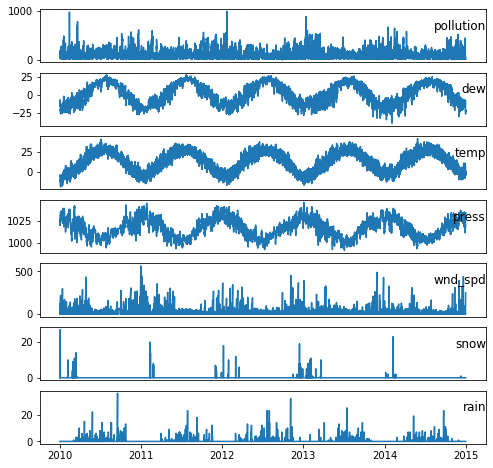

In [39]:
columns = df.columns.values.tolist()
columns.remove('wnd_dir')

plt.figure(figsize = (8,8))
for index,column in enumerate(columns):
    plt.subplot(len(columns),1,index+1)
    plt.plot(df[column])
    plt.title(column,y= 0.5,loc ='right')
    if (column != 'rain'):
        plt.xticks([])

# Converting to supervised problem

Note that the **series_to_supervised()** function was borrowed from Brownlee <cite data-cite="8115705/4QWWIWSF"></cite>

In [40]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """ function that receives numpy array or list of the data and converts it to a supervised dataset by creating
    time shifted data.
    Arguments:
    data: the dataframe in numpy array or list format
    n_in: this refers to how far back the algorithm should start the shifting
    
    i.e. if set to 1, then the current data would be at time = t-1
    
    n_out: this refers to how far forward the algorithm should do the forecasting for
    i.e. if set to 1, then the 'forecast' would be until time = t
    
    dropnan: option to remove the the nan values 
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [41]:
#practice run

# load dataset
values = df.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1,1)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.128902,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0,0.148036,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0
2,0.148036,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0,0.159114,0.426471,0.229508,0.545454,0.666667,0.005522,0.000000,0.0
3,0.159114,0.426471,0.229508,0.545454,0.666667,0.005522,0.000000,0.0,0.181269,0.485294,0.229508,0.563637,0.666667,0.008690,0.037037,0.0
4,0.181269,0.485294,0.229508,0.563637,0.666667,0.008690,0.037037,0.0,0.137966,0.485294,0.229508,0.563637,0.666667,0.010265,0.074074,0.0
5,0.137966,0.485294,0.229508,0.563637,0.666667,0.010265,0.074074,0.0,0.108761,0.485294,0.213115,0.563637,0.666667,0.011840,0.111111,0.0


Note thst at this point, we can use the data at (t-1) to 'predict' the data at (t). This makes the problem supervised, since the (t) parameters are now the target variable (**Y**) and the (t-1) are the predictors (**X**). Since we are only interested in predicting the 'pollution' (this would be variable 1), we can discard all of the target variables that are not pollution.

In [42]:
# discard other variables

reframed.drop(reframed.columns[[i for i in range(9,len(reframed.columns))]],axis = 1,inplace = True)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.128902,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0,0.148036
2,0.148036,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0,0.159114
3,0.159114,0.426471,0.229508,0.545454,0.666667,0.005522,0.000000,0.0,0.181269
4,0.181269,0.485294,0.229508,0.563637,0.666667,0.008690,0.037037,0.0,0.137966
5,0.137966,0.485294,0.229508,0.563637,0.666667,0.010265,0.074074,0.0,0.108761


# Preparing data for modelling

Note that at this point, the data has already been noramlized due to **series_to_supervised()**

In [43]:
values = reframed.values
X = values[:,:-1]
y = values[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 42)
""" Note: this is actually incorrect... we are not trying to test the accuracy of the model... we want to see 
how well is can FORECAST data. Therefore the best way to do this is to split the data chronologically and not 
randomly """

# reshape into 3D [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
""" Not sure what the 'timesteps' reshape is achieving here... I understand what it does conceptually though """


(31315, 1, 8) (10439, 1, 8) (31315,) (10439,)


" Not sure what the 'timesteps' reshape is achieving here... I understand what it does conceptually though "

Epoch 1/50
435/435 - 2s - loss: 0.0287 - val_loss: 0.0144
Epoch 2/50
435/435 - 1s - loss: 0.0134 - val_loss: 0.0143
Epoch 3/50
435/435 - 1s - loss: 0.0133 - val_loss: 0.0140
Epoch 4/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0134
Epoch 5/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0131
Epoch 6/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0134
Epoch 7/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0135
Epoch 8/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0134
Epoch 9/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0132
Epoch 10/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0132
Epoch 11/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0134
Epoch 12/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0133
Epoch 13/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0130
Epoch 14/50
435/435 - 1s - loss: 0.0132 - val_loss: 0.0130
Epoch 15/50
435/435 - 1s - loss: 0.0131 - val_loss: 0.0131
Epoch 16/50
435/435 - 1s - loss: 0.0131 - val_loss: 0.0132
Epoch 17/50
435/435 - 1s - loss: 0.0131 - val_loss: 0.0131
Epoch 

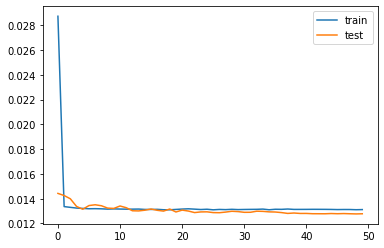

In [44]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Test RMSE: 24.617


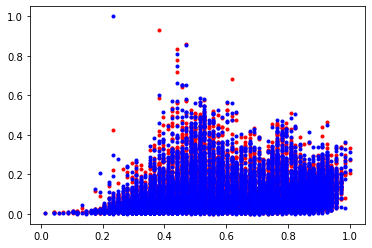

In [45]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

plt.plot(X_test[:,1],yhat,'r.')
plt.plot(X_test[:,1],y_test,'b.')

# References
<div class="cite2c-biblio"></div>